In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
from scipy import stats as st

__Функция для округления__ значений столбцов до бóльшего целого:

In [2]:
def rounding(duration):
    duration = math.ceil(duration)
    return duration

__Функции для расчета стоимости__ сверх включенных в тариф:

In [3]:
#минут

def tariff_min(row):
    tariff = row['tariff']
    summa = row[i]
    if tariff == 'ultra':
        rubles = summa - 3000
    elif tariff == 'smart': 
        rubles = (summa - 500) * 3
    if rubles <= 0:
        return 0
    else:
        return rubles

In [4]:
#мегабайт

def tariff_mb(row):
    tariff = row['tariff']
    summa = row[j]
    if tariff == 'ultra':
        rubles = (summa - 1024*30) * 150/1024
    elif tariff == 'smart':
        rubles = (summa - 1024*15) * 200/1024
    if rubles <= 0:
        return 0
    else:
        return rubles

In [5]:
#смс

def tariff_sms(row):
    tariff = row['tariff']
    summa = row[k]
    if tariff == 'ultra':
        rubles = summa - 1000
    elif tariff == 'smart':
        rubles = (summa - 50) * 3
    if rubles <= 0:
        return 0
    else:
        return rubles

__Функция для расчета помесячной оплаты__, передается строка. 
Рассматриваются четыре варианта: 1. рассматриваемый месяц лежит между месяцем регистрации и месяцем окончания договора; 2.  месяц является месяцем регистрации; 3. месяц является месяцем окончания договора; 4. месяц до регистрации или после окончания договора.

In [6]:
def monthly_fee(row):
    tariff = row['tariff']
    if row['reg_date'].month < month < row['churn_date'].month: 
        #если месяц, который мы рассматриваем в цикле в данный момент, 
        #больше месяца регистрации и меньше месяца окончания договора,
        #начисляется полная месячная плата согласно тарифу
        if tariff == 'smart':
            return (row[j] + 550)
        elif tariff == 'ultra':
            return (row[j] + 1950)
    elif row['reg_date'].month == month:
        #если месяц совпадает с месяцем регистрации пользователя, то плата начисляется со дня регистрации, согласно тарифу
        #причем высчитывается размер тарифа по дням в зависимости от кол-ва дней в месяце
        day = row['reg_date'].day
        month_days = row['reg_date'].days_in_month
        if tariff == 'smart':
            return round(row[j] + 550/month_days * (month_days-day), 1)
        elif tariff == 'ultra':
            return round(row[j] + 1950/month_days * (month_days-day),1)
    elif row['churn_date'].month == month:
        #если месяц совпадает с месяцем окончания договора, то плата начисляется до дня окончания договора
        day = row['churn_date'].day
        month_days = row['churn_date'].days_in_month
        if tariff == 'smart':
            return round((row[j] + 550/month_days * day),1)
        elif tariff == 'ultra':
            return round((row[j] + 1950/month_days * day),1)
    else:
        return row[j]

Функция для расчета продолжительности пользования тарифом в 2018-м году, возвращает число float месяцев с одним знаком после запятой.

In [7]:
def duration(row):
    months = round(
        (row['churn_date'].month - row['reg_date'].month) - \
        row['reg_date'].day/row['reg_date'].days_in_month + row['churn_date'].day/row['churn_date'].days_in_month, 2)
    return months

In [8]:
data_calls = pd.read_csv('/datasets/calls.csv')

In [9]:
data_internet = pd.read_csv('/datasets/internet.csv')

In [10]:
data_messages = pd.read_csv('/datasets/messages.csv')

In [11]:
data_tariffs = pd.read_csv('/datasets/tariffs.csv')

In [12]:
data_users = pd.read_csv('/datasets/users.csv')

# Предобработка и вычисления для дальнейшего анализа

__Данные пользователей__
Мы проверяем таблицу на наличие дубликатов, пустых значений (они есть в столбце churn_date, заменены на "0"), а также смотрим разброс значений. Даты надо перевести в формат DatetimeIndex.

In [13]:
data_users.info()
data_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [14]:
data_users.duplicated().sum()

0

In [15]:
data_users.isnull().sum()

user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

In [16]:
data_users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [17]:
data_users['churn_date'] = data_users['churn_date'].fillna('2018-12-31') 
#полагаю, отсутствие даты окончания договора говорит о том, что пользование тарифом все еще продолжается
#указание даты для всех пользователей облегчит в дальнейшем расчет помесячной оплаты и средних значений по месяцам

In [18]:
data_users['churn_date'] = pd.to_datetime(data_users['churn_date'], format='%Y-%m-%d', errors='coerce')

In [19]:
data_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

In [20]:
data_users['reg_date'] = pd.to_datetime(data_users['reg_date'], format='%Y-%m-%d')

Для удобства дальнейшего анализа я полагаю необходимым удалить пользователей, которые подключились 31.12.2018.

In [21]:
data_users = data_users[data_users['reg_date']<'2018-12-31']

In [22]:
data_users['tariff'].value_counts()

smart    349
ultra    148
Name: tariff, dtype: int64

Создадим отдельный датафрейм с идентификатором пользователя и его тарифом, который мы будем использовать в дальнейшем для расчета расходов пользователей.

In [23]:
users_tariff = data_users.loc[:, ['user_id', 'tariff']]

__Звонки__
Как обычно, мы проверим пустые значения, дубликаты, переведем дату в верный формат, добавим столбец с месяцем звонков.

In [24]:
data_calls.info()
data_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [25]:
data_calls.duplicated().sum()

0

In [26]:
data_calls.isnull().sum()

id           0
call_date    0
duration     0
user_id      0
dtype: int64

In [27]:
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')

In [28]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

In [29]:
duration_0 = data_calls.query('duration == 0')

In [30]:
duration_0['user_id'].value_counts().head()

1377    336
1168    308
1453    295
1375    290
1196    262
Name: user_id, dtype: int64

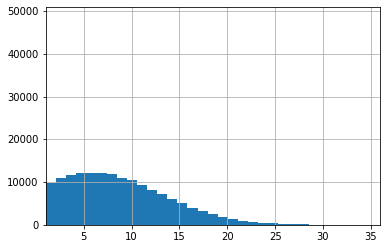

In [31]:
plt.xlim(1,36)
data_calls['duration'].hist(bins=36)

Поменяв на гистограмме значения оси х (от 1), мы видим, что в таком виде распределение выглядит близко к нормальному, хотя и скошено вправо. Я также проверяю, что нулевые значения встречаются в разные дни и у разных пользователей. 
Если биллинговый отдел производит расчеты по таким же данным, то за "нулевые" звонки плата не начисляется, и убрав строки с этим значением, я не искажу размер выручки.

In [32]:
data_calls = data_calls[data_calls['duration'] != 0]

__Округление минут в бóльшую сторону__

In [33]:
data_calls['duration'] = data_calls['duration'].apply(rounding)

Создание __сводной таблицы data_calls_id__, где по каждому пользователю будет отражено количество звонков и истраченных минут в каждом месяце.

In [34]:
data_calls_id = data_calls.pivot_table(index='user_id', columns='month', values='duration', aggfunc=('count', 'sum'), fill_value=0)

In [35]:
data_calls_id.columns = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12',\
                         's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12']

Я создам датафрейм, где запишу количество использованных минут по месяцам. Затем я пересчитаю эти данные в траты за минуты сверх включенных в тариф.

In [36]:
data_calls_spent = data_calls_id.loc[:, ('c1'):('c12')]

In [37]:
data_calls_spent = data_calls_spent.merge(users_tariff, on='user_id', how='right')

In [38]:
data_calls_spent.head()

,user_id,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,tariff
0,1000,0.0,0.0,0.0,0.0,17.0,28.0,41.0,42.0,46.0,44.0,37.0,38.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0,47.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,14.0,21.0,37.0,25.0,24.0,25.0,27.0,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,105.0,97.0,95.0,88.0,ultra
4,1004,0.0,0.0,0.0,0.0,7.0,25.0,20.0,18.0,18.0,21.0,15.0,15.0,ultra


В цикле ниже я переберу колонки, чтобы в каждом месяце посчитать траты на звонки сверх включенных в тариф минут.

In [39]:
for i in range(1,13):
    data_calls_spent[data_calls_spent.columns[i]] = data_calls_spent.apply(tariff_min, axis=1)

In [40]:
data_calls_spent.head()

,user_id,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,tariff
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra


Теперь мы также обработаем __таблицу data_internet__

In [41]:
data_internet.info()
data_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [42]:
data_internet.duplicated().sum()

0

In [43]:
data_internet.isnull().sum()

id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

In [44]:
data_internet.query('mb_used == 0').head()

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000


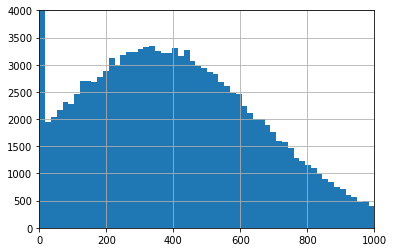

In [45]:
plt.xlim(0,1000)
plt.ylim(0, 4000)
data_internet['mb_used'].hist(bins=100)

Как и в случае звонков мы видим, что нулевое значение трафика встречается у разных пользователей и в разные дни.

С помощью гистограммы я выяснила до какой величины присутствуют выбросы - до 16 мБ включительно, но решила использовать все ненулевые значения для дальнейшего анализа, так как тарификация идет по мБ.

In [46]:
data_internet = data_internet[data_internet['mb_used']>= 0]

In [47]:
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')

In [48]:
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

In [49]:
data_internet['mb_used'] = data_internet['mb_used'].apply(rounding)

In [50]:
data_internet_id = data_internet.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum', fill_value=0)

In [51]:
data_internet_id.head()

month,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,0,0,0,0,2256,23257,14016,14070,14581,14717,14768,9827
1001,0,0,0,0,0,0,0,0,0,0,18452,14053
1002,0,0,0,0,0,10871,17601,20347,16712,13905,18610,18137
1003,0,0,0,0,0,0,0,8571,12479,14779,11368,10132
1004,0,0,0,0,13415,17619,22243,28607,15125,18494,15631,18038


In [52]:
data_internet_id.columns = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']

Создаем датафрейм для подсчета трат за трафик сверх включенных в тариф.

In [53]:
data_internet_spent = data_internet_id.copy(deep=True)

In [54]:
data_internet_spent = data_internet_spent.merge(users_tariff, on='user_id', how='right')

In [55]:
data_internet_spent.head()

,user_id,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,tariff
0,1000,0.0,0.0,0.0,0.0,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18452.0,14053.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8571.0,12479.0,14779.0,11368.0,10132.0,ultra
4,1004,0.0,0.0,0.0,0.0,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0,ultra


В цикле проходим все столбцы (месяца) и считаем расходы на интернет в зависимости от тарифа.

In [56]:
for j in range(1,13):
    data_internet_spent[data_internet_spent.columns[j]] = data_internet_spent.apply(tariff_mb, axis=1)

In [57]:
for j in range(1,13):
    data_internet_spent[data_internet_spent.columns[j]] = \
    data_internet_spent[data_internet_spent.columns[j]].round(1)

In [58]:
data_internet_spent.head()

,user_id,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,tariff
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,603.9,0.0,smart
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,437.7,974.0,264.1,0.0,634.8,542.4,smart
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra


Проделаем все те же операции с __датафреймом data_messages__: проверим наличие дубликатов и нулевых значений, преобразуем даты в тип datetime, создадим датафрейм для расчета трат на сообщения сверх включенных в тариф.

In [59]:
data_messages.info()
data_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [60]:
data_messages.duplicated().sum()

0

In [61]:
data_messages.isnull().sum()

id              0
message_date    0
user_id         0
dtype: int64

In [62]:
data_messages['message_date'] = pd.to_datetime(data_messages['message_date'], format='%Y-%m-%d')

In [63]:
data_messages['month'] = pd.DatetimeIndex(data_messages['message_date']).month

In [64]:
data_messages_id = data_messages.pivot_table(
    index='user_id', columns='month', values='id', aggfunc=('count'), fill_value=0)

In [65]:
data_messages_id.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

In [66]:
data_messages_spent = data_messages_id.merge(users_tariff, on='user_id', how='right')

In [67]:
data_messages_spent.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0,ultra
1,1002,0.0,0.0,0.0,0.0,0.0,4.0,11.0,13.0,4.0,10.0,16.0,12.0,smart
2,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,91.0,83.0,94.0,75.0,ultra
3,1004,0.0,0.0,0.0,0.0,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0,ultra
4,1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0,smart


В цикле для каждого месяца рассчитаем расходы на сообщения по каждому пользователю в зависимости от тарифа.

In [68]:
for k in range(1,13):
    data_messages_spent[data_messages_spent.columns[k]] = data_messages_spent.apply(tariff_sms, axis=1)

In [69]:
data_messages_spent.head()

,user_id,1,2,3,4,5,6,7,8,9,10,11,12,tariff
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,smart
2,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
3,1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1005,0.0,0.0,18.0,0.0,0.0,0.0,18.0,42.0,6.0,0.0,3.0,12.0,smart


Теперь посчитаем __общую выручку__ по по месяцам по каждому пользователю. Для этого объединим с таблицей users_tariff поочередно таблицы data_messages_spent, data_internet_spent, data_calls_spent.

In [70]:
users_spent = users_tariff.merge(data_messages_spent, on='user_id', how='left')

In [71]:
del users_spent['tariff_y']

In [72]:
users_spent = users_spent.merge(data_internet_spent, on='user_id', how='left')

In [73]:
users_spent = users_spent.fillna(0)

In [74]:
users_spent.head()

,user_id,tariff_x,1,2,3,4,5,6,7,8,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,tariff
0,1000,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,603.9,0.0,smart
2,1002,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,437.7,974.0,264.1,0.0,634.8,542.4,smart
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra
4,1004,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ultra


В цикле ниже мы сложим траты на сообщения и интернет по месяцам, сохраним значения в столбцах "1", "2" ... "12" и удалим ставшие ненужными столбцы (sum,1)... (sum,12)

In [75]:
for m in range(2,14):
    users_spent[users_spent.columns[m]] = users_spent[users_spent.columns[m]] + users_spent[users_spent.columns[m+12]]

In [76]:
users_spent = users_spent.loc[:, 'user_id': '12']

In [77]:
users_spent = users_spent.merge(data_calls_spent, on='user_id', how='left')

In [78]:
users_spent = users_spent.fillna(0)

Также прибавляем к сумме трат на сообщения и интернет траты на звонки сверх лимита в тарифах:

In [79]:
for m in range(2,14):
    users_spent[users_spent.columns[m]] = users_spent[users_spent.columns[m]] + users_spent[users_spent.columns[m+12]]

In [80]:
users_spent = users_spent.loc[:, 'user_id': '12']

In [81]:
users_spent.rename(columns={'tariff_x':'tariff'}, inplace=True)

In [82]:
users_spent.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,603.9,0.0
2,1002,smart,0.0,0.0,0.0,0.0,0.0,0.0,437.7,974.0,264.1,0.0,634.8,542.4
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1004,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Далее нам нужно добавить к тратам фиксированную помесячную плату в зависимости от тарифа. Плата взимается за полный месяц, поэтому необходимо предусмотреть перерасчет по месяцам  reg_date и churn_date. 

In [83]:
users_spent = pd.merge(users_spent, data_users[['user_id','reg_date', 'churn_date']],on='user_id', how='left')

In [84]:
users_spent.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12,reg_date,churn_date
0,1000,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-25,2018-12-31
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,603.9,0.0,2018-11-01,2018-12-31
2,1002,smart,0.0,0.0,0.0,0.0,0.0,0.0,437.7,974.0,264.1,0.0,634.8,542.4,2018-06-17,2018-12-31
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-08-17,2018-12-31
4,1004,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-05-14,2018-12-31


In [85]:
for j in range(2,14):
    month = j-1
    users_spent[users_spent.columns[j]] = users_spent.apply(monthly_fee, axis=1)

In [86]:
users_spent.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12,reg_date,churn_date
0,1000,ultra,0.0,0.0,0.0,0.0,377.4,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,2018-05-25,2018-12-31
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1135.6,550.0,2018-11-01,2018-12-31
2,1002,smart,0.0,0.0,0.0,0.0,0.0,238.3,987.7,1524.0,814.1,550.0,1184.8,1092.4,2018-06-17,2018-12-31
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,880.6,1950.0,1950.0,1950.0,1950.0,2018-08-17,2018-12-31
4,1004,ultra,0.0,0.0,0.0,0.0,1069.4,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,1950.0,2018-05-14,2018-12-31


Для расчета среднемесячных трат необходимо вычислить, сколько месяцев клиент пользовался тарифом. Создадим столбец month и заполним его с помощью функции duration. Далее вычислим сумму расходов за год и разделим на количество месяцев пользования тарифов.

In [87]:
users_spent['months'] = users_spent.apply(duration,axis=1)

In [88]:
users_spent['total_revenue'] = users_spent[['1','2', '3', '4', '5', '6', '7', '8', '9', '10', '11','12']].sum(axis=1)

In [89]:
users_spent['mean_revenue'] = (users_spent['total_revenue'] / users_spent['months']).round()

## Анализ данных
Расход минут, сообщений, интернет-трафика в разных тарифах.

### Звонки

In [90]:
quantities_calls = users_tariff.merge(data_calls_id, on='user_id', how='left')

In [91]:
quantities_calls.isnull().sum().head()

user_id    0
tariff     0
c1         8
c2         8
c3         8
dtype: int64

In [92]:
quantities_calls = quantities_calls.fillna(0)

Количество звонков

In [93]:
quantities_calls['total_calls'] = \
quantities_calls[['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9', 'c10', 'c11', 'c12']].sum(axis=1)

Продолжительность звонков

In [94]:
quantities_calls['total_mins'] = \
quantities_calls[['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12']].sum(axis=1)

Добавляем столбец с количеством месяцев использования тарифа для расчета среднемесячного количества звонков.

In [95]:
quantities_calls = quantities_calls.merge(users_spent[['user_id', 'months']], on='user_id', how='left')

In [96]:
quantities_calls['mean_calls'] = (quantities_calls['total_calls'] / quantities_calls['months']).round(0)

In [97]:
quantities_calls['mean_mins'] = (quantities_calls['total_mins'] / quantities_calls['months']).round(0)

In [98]:
quantities_calls.groupby('tariff').agg(
    {'mean_calls':['mean', 'median','var', 'std'], 'mean_mins':['mean', 'median','var', 'std']}).round()

mean_calls                        mean_mins                          
             mean median      var    std      mean median        var     std
tariff                                                                      
smart        65.0   54.0  15199.0  123.0     578.0  476.0  1263673.0  1124.0
ultra        76.0   68.0  10380.0  102.0     675.0  606.0   700135.0   837.0

__Гистограммы среднемесячных значений продолжительности звонков в разных тарифах__

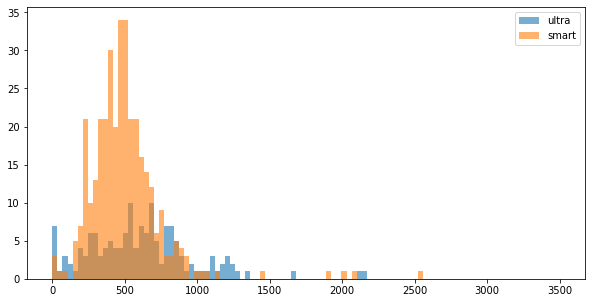

In [99]:
fig=plt.figure(figsize=(10, 5))
plt.hist(
    quantities_calls[quantities_calls["tariff"]=="ultra"]["mean_mins"].reset_index(
        drop=True), alpha=0.6, label="ultra", bins=100, range=(0, 3500))
plt.hist(
    quantities_calls[quantities_calls["tariff"]=="smart"]["mean_mins"].reset_index(
        drop=True), alpha=0.6, label="smart", bins=100, range=(0, 3500))
plt.legend()
plt.show()

__Среднее количество звонков__
Пользователи тарифа "ультра" совершают в среднем на 12% звонков больше, чем пользователи тарифа "смарт". И в том, и в другом случае медиана среднемесячных значений меньше среднего, что говорит об отдельных пользователях с очень большим количеством звонков.
__Средняя продолжительность звонков__
Среднемесячная продолжительность звонков у пользователей тарифа "смарт" превосходит включенный в тариф лимит, а у пользователей тарифа "ультра" - более чем в 4 раз ниже лимита. Среди пользователей лимита "смарт" больше таких, кто разговаривает необычно много (относительно всей выборки), в этой группе медиана существенно ниже среднего, а стандартное отклонение больше, чем в тарифе "ультра".
Распределение среднемесячных величин продолжительности звонков пользователей сходно с нормальным распределением.

In [100]:
quantities_calls.groupby('tariff').agg(
    {'s1':'median', 's2':'median', 's3':'median', 's4':'median', 's5':'median', 's6':'median', 's7':'median',\
     's8':'median', 's9':'median', 's10':'median', 's11':'median', 's12':'median'})

,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
tariff,,,,,,,,,,,,
smart,0.0,0.0,0.0,0.0,0.0,0.0,185.0,297.0,339.0,366.0,408.0,464.0
ultra,0.0,0.0,0.0,0.0,0.0,88.5,248.0,343.0,376.5,443.5,513.5,568.0


Выше я посчитала среднюю продолжительность звонков по месяцам. Отсюда можно сделать только осторожный вывод о том, что со временем продолжительность разговоров растет.

### Интернет-трафик

In [101]:
quantities_mb = users_tariff.merge(data_internet_id, on='user_id', how='left')

In [102]:
quantities_mb.isnull().sum().head()

user_id    0
tariff     0
m1         3
m2         3
m3         3
dtype: int64

In [103]:
quantities_mb = quantities_mb.fillna(0)

In [104]:
quantities_mb.head()

,user_id,tariff,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12
0,1000,ultra,0.0,0.0,0.0,0.0,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1,1001,smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18452.0,14053.0
2,1002,smart,0.0,0.0,0.0,0.0,0.0,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8571.0,12479.0,14779.0,11368.0,10132.0
4,1004,ultra,0.0,0.0,0.0,0.0,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0


In [105]:
quantities_mb['total_mb'] = \
quantities_mb[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']].sum(axis=1)

Добавляем столбец с количеством месяцев использования тарифа для расчета среднемесячного трафика.

In [106]:
quantities_mb = quantities_mb.merge(users_spent[['user_id', 'months']], on='user_id', how='left')

In [107]:
quantities_mb['mean_gb'] = (quantities_mb['total_mb'] / quantities_calls['months'] / 1024).round(2)

In [108]:
quantities_mb.groupby('tariff').agg(
    {'mean_gb':['mean', 'median','var', 'std']}).round()

mean_gb                     
          mean median     var   std
tariff                             
smart     21.0   18.0  1626.0  40.0
ultra     25.0   21.0  1019.0  32.0

__Гистограммы среднемесячных значений использованного трафика__

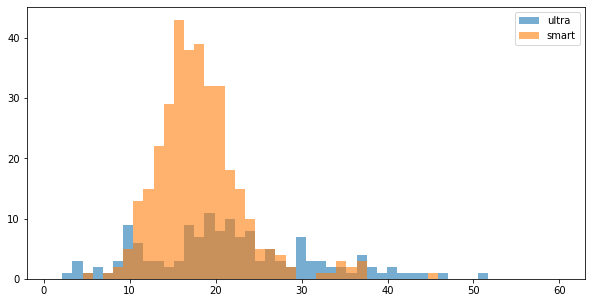

In [109]:
fig=plt.figure(figsize=(10, 5))
plt.hist(
    quantities_mb[quantities_mb["tariff"]=="ultra"]["mean_gb"].reset_index(
        drop=True), alpha=0.6, label="ultra", bins=50, range=(1, 60))
plt.hist(
    quantities_mb[quantities_mb["tariff"]=="smart"]["mean_gb"].reset_index(
        drop=True), alpha=0.6, label="smart", bins=50, range=(1, 60))
plt.legend()
plt.show()

Я посчитала среднее количество помесячного трафика в __гигабайтах__ для удобства рассмотрения.
Мы видим, что __пользователи тарифа "смарт" очень существенно превышают включенный в тариф лимит трафика, а пользователи тарифа "ультра" укладываются в свой лимит__.
И для одного, и для второго тарифа виден большой разброс вокруг среднего значения, особенно стандартное отклонение велико у пользователей тарифа "смарт", то есть ряд пользователей использует гораздо больше трафика (и им стоит порекомендовать перейти на тариф "ультра").

### Сообщения

In [110]:
quantities_messages = users_tariff.merge(data_messages_id, on='user_id', how='left')

In [111]:
quantities_messages.head()

,user_id,tariff,1,2,3,4,5,6,7,8,9,10,11,12
0,1000,ultra,0.0,0.0,0.0,0.0,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1,1001,smart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1002,smart,0.0,0.0,0.0,0.0,0.0,4.0,11.0,13.0,4.0,10.0,16.0,12.0
3,1003,ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0,91.0,83.0,94.0,75.0
4,1004,ultra,0.0,0.0,0.0,0.0,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0


In [112]:
quantities_messages = quantities_messages.fillna(0)

In [113]:
quantities_messages['total_sms'] = \
quantities_messages[['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']].sum(axis=1)

In [114]:
quantities_messages = quantities_messages.merge(users_spent[['user_id', 'months']], on='user_id', how='left')

In [115]:
quantities_messages['mean_sms'] = (quantities_messages['total_sms'] / quantities_messages['months']).round(0)

In [116]:
quantities_messages.groupby('tariff').agg({'mean_sms':['mean', 'median','var', 'std']}).round()

mean_sms                       
           mean median      var    std
tariff                                
smart      42.0   32.0   5484.0   74.0
ultra      79.0   50.0  45882.0  214.0

__Гистограммы среднемесячного количества отправленных сообщение пользователей тарифов "ультра" и "смарт".__

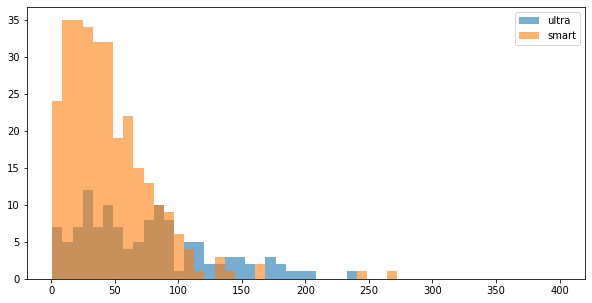

In [117]:
fig=plt.figure(figsize=(10, 5))
plt.hist(
    quantities_messages[quantities_messages["tariff"]=="ultra"]["mean_sms"].reset_index(
        drop=True), alpha=0.6, label="ultra", bins=50, range=(1, 400))
plt.hist(
    quantities_messages[quantities_messages["tariff"]=="smart"]["mean_sms"].reset_index(
        drop=True), alpha=0.6, label="smart", bins=50, range=(1, 400))
plt.legend()
plt.show()

Как и следовало ожидать, пользователи тарифа "ультра" отправляют больше сообщений, чем пользователи тарифа "смарт". 
График распределения среднемесячного количества сообщений в тарифе "смарт" напоминает распределение Пуассона: большинство пользователей отправляют мало сообщений. 
То, что среднее в обоих случаях превосходит медиану, говорит о нескольких пользователях, которые отправляют очень много сообщений.
Также из этого графика мы можем заключить, что пользователи тарифа "смарт" часто превышают включенный в тариф лимит сообщений (50), а пользователи тарифа "ультра" в большинстве своем вписываются в лимит (1000).

In [118]:
quantities_messages.groupby('tariff').agg(
    {'1':'median', '2':'median', '3':'median', '4':'median', '5':'median', '6':'median', '7':'median',\
     '8':'median', '9':'median', '10':'median', '11':'median', '12':'median'})

,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,21.0,25.0,29.0
ultra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.5,25.0,35.0,39.0,48.5


Я также хотела проследить статистику отправки по месяцам, но здесь не достаточно данных.

## Проверка гипотез

In [119]:
revenues = users_spent.loc[:, ['user_id', 'tariff', 'mean_revenue']]

In [120]:
revenues = revenues.merge(data_users[['user_id', 'city']], on='user_id', how='left')

In [121]:
revenues.loc[revenues['city'] != 'Москва', 'city'] = 'другой'

In [122]:
revenues.head()

,user_id,tariff,mean_revenue,city
0,1000,ultra,1951.0,другой
1,1001,smart,856.0,Москва
2,1002,smart,994.0,другой
3,1003,ultra,1951.0,Москва
4,1004,ultra,1950.0,другой


In [123]:
revenues.query('tariff=="ultra" and mean_revenue <=1950').count()

user_id         71
tariff          71
mean_revenue    71
city            71
dtype: int64

In [124]:
revenues.query('tariff == "smart" and mean_revenue <=550').count()

user_id         25
tariff          25
mean_revenue    25
city            25
dtype: int64

Интересно, что в среднем __только 7% (25 из 349) пользователей тарифа "смарт"__ ограничиваются использованием включенных в тариф минут, трафика и сообщений. Вдвое больше клиентов, 14% (49 из 349) тратят в месяц 1950 рублей и больше, то есть столько же или больше, сколько пользователи тарифа "ультра".
В то же время __среди пользователей тарифа "ультра" в месячный лимит вписываются 48%__ (71 из 148).

###  Сравнение выручки по разным тарифам

In [125]:
revenues.groupby('tariff').agg({'mean_revenue':['mean', 'median','var', 'std', 'sum']}).round()

mean_revenue                                     
               mean  median        var     std       sum
tariff                                                  
smart        1400.0  1054.0  5758026.0  2400.0  488554.0
ultra        2117.0  1951.0   145996.0   382.0  313290.0

Сравнивая основные параметры выборок, мы видим, что __средняя выручка по тарифу "смарт" ниже выручки по тарифу "ультра"__. Превышение средних значений над медианами говорит о том, что есть большой "хвост" значений справа, значений, значительно превосходящих средние.

__В тарифе "смарт" стандартное отклонение очень велико__, это мы наблюдали и ранее, при анализе средних значений звонков, трафика и сообщений. То есть есть пользователи, которые используют существенно больше звонков, сообщений и трафика. Соответственно, и выручка с них гораздо выше средних значений.

Чтобы проверить гипотезу о различиях средней выручки в тарифах "смарт" и "ультра", создадим отдельные переменные для средних значений тарифов "ультра" и "смарт". 
Нулевая гипотеза звучит так: "средняя выручка пользователей тарифов не отличается". 
Уровень значимости: 0.5
Выборки независимы.

In [126]:
smart_revenues = revenues[revenues['tariff'] == 'smart']['mean_revenue']

In [127]:
ultra_revenues = revenues[revenues['tariff'] == 'ultra']['mean_revenue']

In [128]:
results = st.ttest_ind(smart_revenues, ultra_revenues)
print(results.pvalue)

0.0003330500054632321


Полученное значение p-value говорит о том, что вероятность схожести выборок очень мала, то есть __средняя выручка пользователей тарифов "смарт" и "ультра"__ отличается. Среднее выборок указывает на то, что __выручка по тарифу "ультра" статистически значимо выше__.

### Сравнение выручки в Москве и других городах

In [129]:
revenues.groupby('city').agg({'mean_revenue':['mean', 'median','var', 'std']}).round()

mean_revenue                           
               mean  median        var     std
city                                          
Москва       1517.0  1495.0   805348.0   897.0
другой       1637.0  1444.0  5034295.0  2244.0

__Средние и медианы в выборках "Москва" и "другие города" схожи__, медиана в обоих случаях меньше среднего. Но мы видим, что стандартное отклонение в "других городах" гораздо больше, чем в Москве. Очевидно, там есть ряд экстремальных значений. Влияют ли они на выручку мы проверим, сравнив совокупности.
Нулевая гипотеза: среднее значение выручки в группах "Москва" и "другие города" не отличается.
Уровень значимости: 5%
Выборки независимы.

In [130]:
revenues.query('city == "Москва" and tariff == "ultra"').count()

user_id         32
tariff          32
mean_revenue    32
city            32
dtype: int64

In [131]:
moscow_revenues = revenues[revenues['city'] == 'Москва']['mean_revenue']

In [132]:
other_cities_revenues = revenues[revenues['city'] == 'другой']['mean_revenue']

In [133]:
results = st.ttest_ind(moscow_revenues, other_cities_revenues)
print(results.pvalue)

0.602950971147904


С вероятностью 60% средняя выручка в Москве не отличается от средней выручки в других городах.

## Заключение
1. Чтобы делать более обоснованные выводы о поведении пользователей двух тарифов, полагаю, было бы лучше изучить пользователей, которые пользовались тарифами в течение всего года.
2. Среднемесячная выручка от тарифа "ультра" в 1,5 раза выше выручки от тарифа "ультра", несмотря даже на то, что более 90% пользователей тарифа "смарт" превышают ежемесячные лимиты и тратят больше ежемесячного тарифа.
3. В то же время, в выборке более чем в два раза больше пользователей тарифа "смарт", чем тарифа "ультра", и в сумме они приносят бóльшую среднемесячную выручку. 
4. Пользователям тарифа "смарт", которые тратят в среднем больше 1950 рублей в месяц, имеет смысл предложить перейти на тариф "ультра".
5. Среднемесячная выручка от пользователей в Москве схожа с выручкой в совокупности других регионов.